# Задание по курсу "Практическое введение в анализ изображений"
Подготовила студентка группы 208 Пескова Карина


Для начала установим пакет `petroscope`.


In [1]:
!pip install petroscope --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78

Код ниже позволит работать с данными на диске

Путь до файлов на диске:

dev -> intro_course_prak -> LumenStone -> S1_v1.5

In [3]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ds_path = Path('/content/drive/MyDrive/dev/intro_course_prak/LumenStone/S1_v1')

Mounted at /content/drive


Для работы с данными используем библиотеку petroscope, выведем номер, название и цвет класса каждого минерала.

In [4]:
from petroscope.segmentation.classes import ClassSet, LumenStoneClasses

classset = LumenStoneClasses.S1v1()
for cl in classset.classes:
    print(cl)

[0, bg (background), color: #000000]
[1, ccp/kub (chalcopyrite/cubanite), color: #ffa500]
[2, gl (galena), color: #9acd32]
[4, brt (bornite), color: #00bfff]
[6, py/mrc (pyrite/marcasite), color: #2f4f4f]
[8, sph (sphalerite), color: #ee82ee]
[11, tnt/ttr (tenantite/tetrahedrite), color: #483d8b]


Для наглядности покажем прямоугольнички в цвет каждого минерала.

Class code:  0


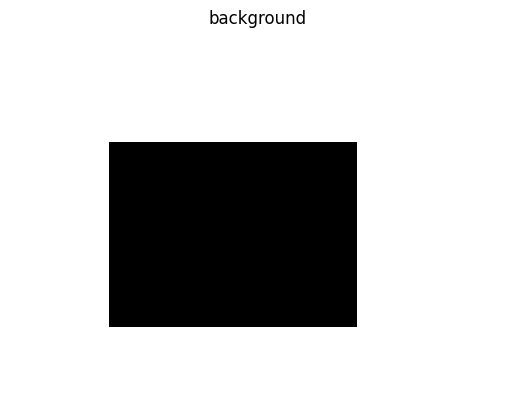

Class code:  1


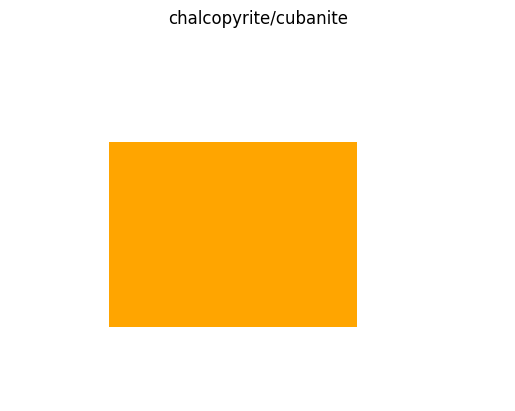

Class code:  2


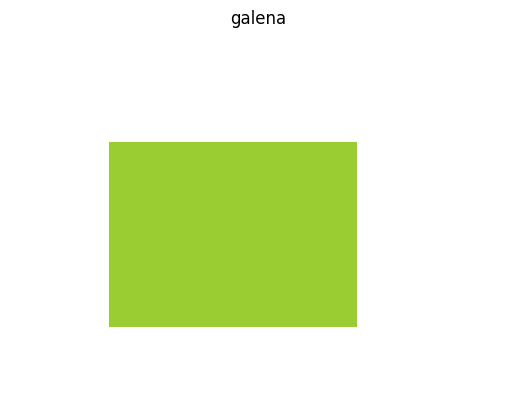

Class code:  4


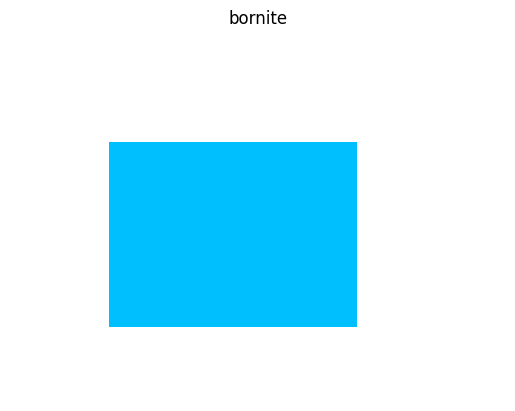

Class code:  6


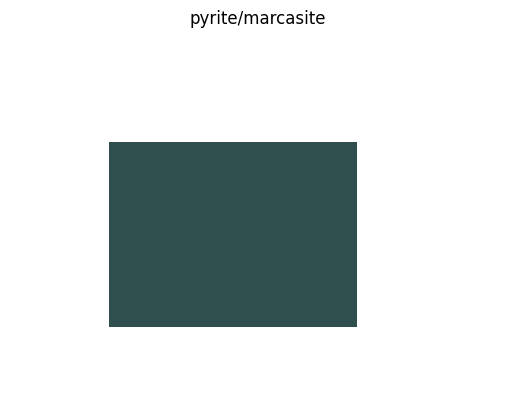

Class code:  8


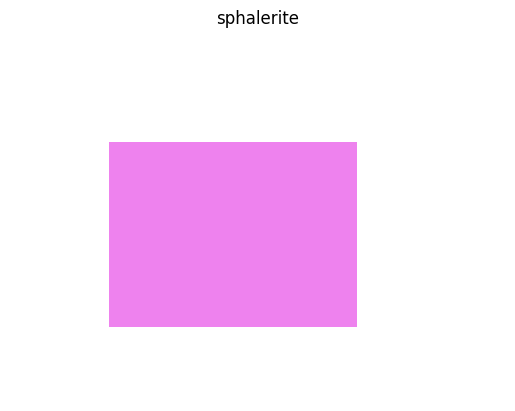

Class code:  11


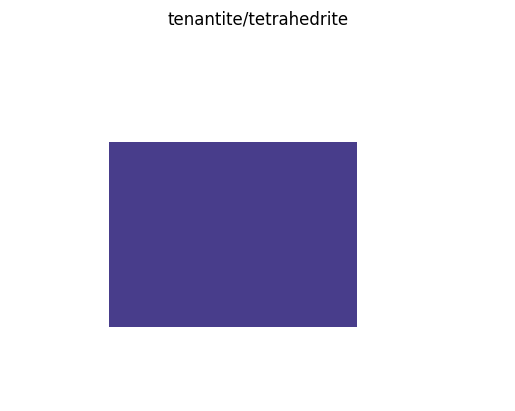

In [5]:
def show_class_color(cl):

  fig, ax = plt.subplots()

  e_color = "black"
  f_color = cl.color
  rect = patches.Rectangle((0.2, 0.2), 0.5, 0.5, facecolor=f_color)

  # Добавляем прямоугольник на оси
  ax.add_patch(rect)

  # Устанавливаем пределы осей для отображения прямоугольника
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)

  title = cl.name
  # Отображаем график
  plt.title(title)
  plt.axis("off")
  plt.show()


from petroscope.segmentation.classes import ClassSet, LumenStoneClasses
import matplotlib.patches as patches
import matplotlib.pyplot as plt

classset = LumenStoneClasses.S1v1()
for cl in classset.classes:
    print("Class code: ", cl.code)
    show_class_color(cl)

Оформим наш стандартный код для отображения изображений в функцию.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def show(image, title: str = None, cmap: str = None):
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

Переходим к написанию кода, который будет решать нашу задачу!

Импортируем все нужные библиотеки.

In [12]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from petroscope.segmentation.classes import ClassSet, LumenStoneClasses
from petroscope.segmentation.utils import load_image, load_mask

Создадим класс нашего датасета

In [13]:
from PIL import Image
class SegmentationDataset(Dataset):
    def __init__(self, img_mask_paths, classes, transform_img=None, transform_mask=None):
        self.img_mask_paths = img_mask_paths
        self.classes = classes
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_mask_paths)

    def __getitem__(self, idx):
        img_path, mask_path = self.img_mask_paths[idx]
        # загрузка изображения и маски
        img = load_image(img_path, normalize=True)
        mask = load_mask(mask_path, classes=self.classes, one_hot=False)

        # преобразование в Image
        img = Image.fromarray((img * 255).astype(np.uint8))
        mask = Image.fromarray(mask.astype(np.uint8))

        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
            # приводим к long, тк будем использовать CrossEntropyLoss
            # в качестве функции потерь, а она работает только с целыми метками
            mask = mask.squeeze(0).long()
        return img, mask



Пояснения к коду ниже:
- Подготовим изображения для подачи в модель. Так как они очень большие, было принято решение их ресайзнуть: сами изображения аншлифов ресайзятся с помощью билинейной интерполяцией, а маски - методом K ближайших соседей. Также изображения мы приводим к формату тензора для того, чтобы передать их модели
- В качестве модели была выбрана модель resnet50. Изначально эта модель расчитана на 21 класс, а у нас их 7 (6 минералов + фон), поэтому последний сверточный слой был заменен
- В качестве оптимизатора используется Adam (по советам Александра Владимировича :) )
- В качестве функции потерь - CrossEntropyLoss

In [27]:
import petroscope.segmentation as segm

class SegmModel(segm.GeoSegmModel):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.num_classes = len(classes.classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # трансформации
        self.transform_img = T.Compose([
            T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor()
        ])
        self.transform_mask = T.Compose([
            T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),
            T.PILToTensor()
        ])

        # модель
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        in_channels = self.model.classifier[4].in_channels
        self.model.classifier[4] = nn.Conv2d(in_channels, self.num_classes, kernel_size=1)
        self.model = self.model.to(self.device)

    def train(self, img_mask_paths, epochs=5, batch_size=4, lr=1e-4, **kwargs):
        dataset = SegmentationDataset(
            img_mask_paths, self.classes,
            transform_img=self.transform_img,
            transform_mask=self.transform_mask
        )
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.model.train()
            if epoch == 0 :
              print(f"step {epoch+1}/{epochs} loss: ---")
            else:
              print(f"step {epoch+1}/{epochs} loss: {total_loss/len(dataloader):.4f}")

            total_loss = 0
            for images, masks in tqdm(dataloader):
                images, masks = images.to(self.device), masks.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)['out']
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

    def predict_image(self, image: np.ndarray) -> np.ndarray:
      self.model.eval()
      with torch.no_grad():
          s = image.shape[:2]
          image_pil = Image.fromarray((image * 255).astype(np.uint8))
          input_tensor = self.transform_img(image_pil).unsqueeze(0).to(self.device)

          output = self.model(input_tensor)['out']
          # возвращаем оригинальные размеры
          output = F.interpolate(output, size=s, mode='bilinear', align_corners=False)
          prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
      return prediction

    def load(self, saved_path: Path, **kwargs):
        self.model.load_state_dict(torch.load(saved_path, map_location=self.device))

    def save(self, save_path: Path, **kwargs):
        torch.save(self.model.state_dict(), save_path)


In [23]:
ds_path = Path('/content/drive/MyDrive/dev/intro_course_prak/LumenStone/S1_v1')

train_img_mask_p = [
    (img_p, ds_path / "masks" / "train" / f"{img_p.stem}.png")
    for img_p in sorted((ds_path / "imgs" / "train").iterdir())
]
test_img_mask_p = [
    (img_p, ds_path / "masks" / "test" / f"{img_p.stem}.png")
    for img_p in sorted((ds_path / "imgs" / "test").iterdir())
]

classset = LumenStoneClasses.S1v1()
model = SegmModel(classset)
model.train(train_img_mask_p, epochs=10)


step 1/10 loss: ---


100%|██████████| 15/15 [00:45<00:00,  3.00s/it]


step 2/10 loss: 1.4512


100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


step 3/10 loss: 1.0167


100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


step 4/10 loss: 0.8782


100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


step 5/10 loss: 0.7261


100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


step 6/10 loss: 0.6548


100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


step 7/10 loss: 0.5390


100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


step 8/10 loss: 0.4715


100%|██████████| 15/15 [00:45<00:00,  3.03s/it]


step 9/10 loss: 0.4592


100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


step 10/10 loss: 0.4260


100%|██████████| 15/15 [00:44<00:00,  3.00s/it]


In [24]:
# сохраним веса модели
save_path = Path("weights.pth")
model.save(save_path)

Сформируем списки путей обучающих и тестовых изображений

Пришло время для тестирования модели :)

In [25]:
from petroscope.segmentation.eval import SegmDetailedTester


tester = SegmDetailedTester(
    Path("output"),
    classes=classset,
    void_pad=0,
    void_border_width=4,
    vis_plots=False,
    vis_segmentation=True,
)

res, res_void = tester.test_on_set(
    test_img_mask_p,
    lambda img: model.predict_image(img),
    description="Results",
    return_void=True,
)

print(f"Metrics:\n{res}")
print(f"Metrics with void borders:\n{res_void}")

testing: 100%|██████████| 16/16 [03:06<00:00, 11.65s/it]

Metrics:
	 iou [soft]:
		 bg: 0.7347 [0.7347]
		 brt: 0.8314 [0.8314]
		 ccp/kub: 0.6134 [0.6134]
		 gl: 0.5751 [0.5751]
		 py/mrc: 0.8463 [0.8463]
		 sph: 0.6680 [0.6680]
		 tnt/ttr: 0.6009 [0.6009]
	 mean iou [soft]: 0.6957 [0.6957]
	 acc: 0.8502

Metrics with void borders:
	 iou [soft]:
		 bg: 0.7823 [0.7823]
		 brt: 0.8580 [0.8580]
		 ccp/kub: 0.6434 [0.6434]
		 gl: 0.6101 [0.6101]
		 py/mrc: 0.8771 [0.8771]
		 sph: 0.7001 [0.7001]
		 tnt/ttr: 0.6260 [0.6260]
	 mean iou [soft]: 0.7281 [0.7281]
	 acc: 0.8813



Визуализируем наши результаты. После тестирования они хранятся в папке Results.


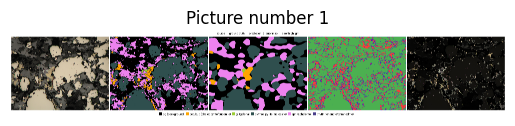

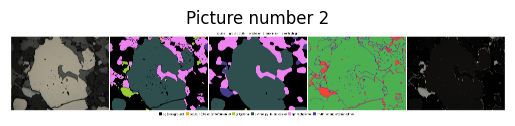

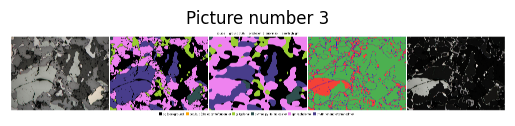

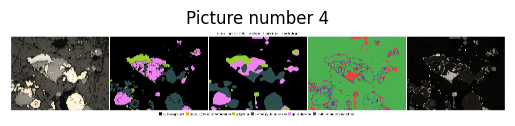

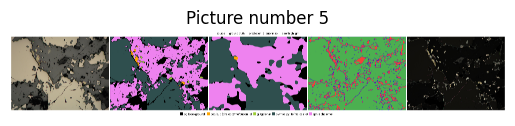

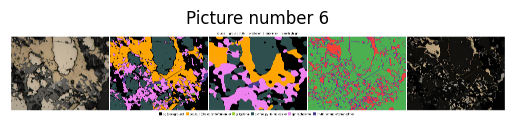

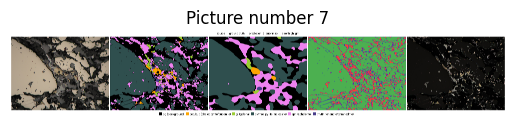

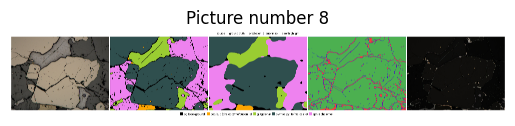

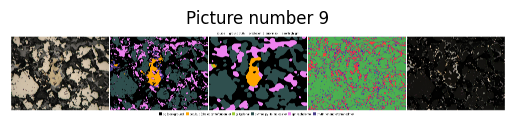

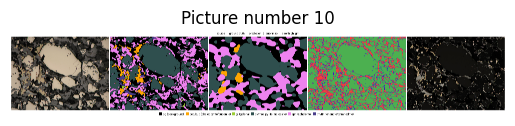

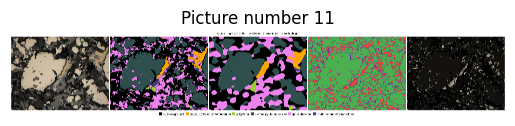

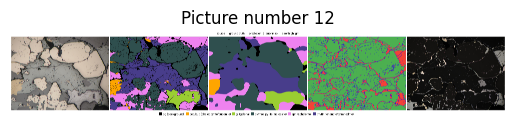

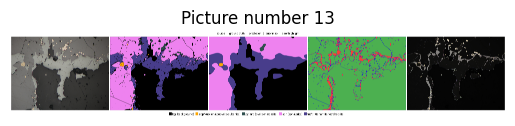

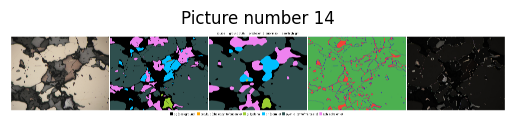

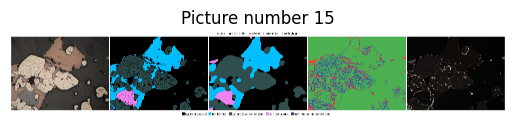

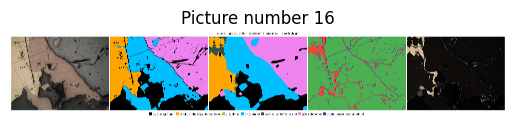

In [26]:
from PIL import Image

for i in range(1, 17):

  num = str(i)
  if i <= 9:
    num = "0" + num

  img_path = f"/content/output/Results/img_{num}_composite.jpg"
  img = Image.open(img_path)
  show(img, f"Picture number {i}")

По полученным метрикам и картинкам несложно заметить, что хуже всего модель угадывает galen, он же галенит, она путает его с sph (сфалерит). Особенно это заметно на картинке 3.

Также модель путает ccp/kub (халькопирит/кубинец) с py (пирит/марказит) и sph (видно на 6-м изображении) и sph с tnt/ttr (теннантит/тетраэдрит) (изображение 12).